In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###Demonstrate using the simulator at the region level, stochastic integration and the BOLD monitor:   

- how to perform a simulation continuation, that is, to use data from one
simulation as initial conditions for a second simulation (ie, simulation
continuation) in order to avoid the temporal transient due to imperfect
initial conditions.

- how to save the random number generator state. 

In [3]:
from tvb.simulator.lab import *
import glob

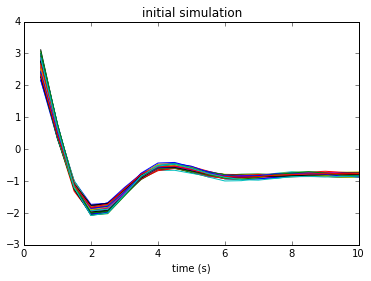

In [4]:
######## build & run the initial simulation, if cryo file doesn't exist
try:
    os.stat('sim_cryo.npz')
    print 'old simulation found! moving along...'

except OSError:     # os.stat will give OSError if it doesn't find the file
    
    print 'old simulation not found, performing initial'

    oscillator = models.Generic2dOscillator()
    white_matter = connectivity.Connectivity(load_default=True)
    white_matter.speed = numpy.array([4.0])
    white_matter_coupling = coupling.Linear(a=0.0126)

    heunint = integrators.HeunStochastic(dt=2 ** -4,
                                         noise=noise.Additive(nsig=array([0.001])))

    #Initialise some Monitors with period in physical time
    tavg = monitors.TemporalAverage(period=1.0)     # 1000Hz
    bold = monitors.Bold(period=500)    # defaults to one data point every 500ms

    #Bundle them
    what_to_watch = (tavg, bold)

    #Define the stimulus
    #Specify a weighting for regions to receive stimuli... 
    white_matter.configure()    # Because we want access to number_of_regions
    nodes = [0, 7, 13, 33, 42]
    weighting = numpy.zeros((white_matter.number_of_regions, ))
    weighting[nodes] = numpy.array([2.0 ** -2, 2.0 ** -3, 2.0 ** -4, 2.0 ** -5, 2.0 ** -6])

    #Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and stimulus.
    sim = simulator.Simulator(model=oscillator, connectivity=white_matter,
                              coupling=white_matter_coupling,
                              integrator=heunint, monitors=what_to_watch)
    sim.configure()

    #Perform the simulation
    tavg_time = []
    tavg_data = []
    bold_time = []
    bold_data = []

    for tavg_out, bold_out in sim(10000):    # 10 s simulation
        
        if not tavg_out is None:
            tavg_time.append(tavg_out[0])
            tavg_data.append(tavg_out[1])
        
        if not bold_out is None:
            bold_time.append(bold_out[0])
            bold_data.append(bold_out[1])


    # plot data to show the transient
    figure(1)
    plot(array(bold_time) / 1000.0, array(bold_data)[:, 0, :, 0])
    title('initial simulation')
    xlabel('time (s)')

    # now, save the state: sim history, bold stock & noise generator state
    history = sim.history.copy()
    bold1 = sim.monitors[1]._interim_stock.copy()
    bold2 = sim.monitors[1]._stock.copy()
    rng = sim.integrator.noise.random_stream.get_state()

    # save to file (sorry this is cryptic for the moment)
    savez('sim_cryo.npz', history=history, bold1=bold1, bold2=bold2)
    save('rng_%s_%d_%d_%.30g.npy' % ((rng[0],) + rng[2:]), rng[1])

 ####Now the continuation of the previous simulation

In [5]:
# build new simulator, possibly in a different script

oscillator = models.Generic2dOscillator()
white_matter = connectivity.Connectivity(load_default=True)
white_matter.speed = numpy.array([4.0])
white_matter_coupling = coupling.Linear(a=0.0126)

heunint = integrators.HeunStochastic(dt=2 ** -4,
                                     noise=noise.Additive(nsig=array([0.001])))

In [6]:
#Initialise some Monitors with period in physical time
tavg = monitors.TemporalAverage(period=1.0)     # 1000Hz
bold = monitors.Bold(period=500)        # defaults to one data point every 500ms

#Bundle them
what_to_watch = (tavg, bold)

In [7]:
#Define the stimulus
#Specify a weighting for regions to receive stimuli... 
white_matter.configure()    # Because we want access to number_of_regions
nodes = [0, 7, 13, 33, 42]
weighting = numpy.zeros((white_matter.number_of_regions, ))
weighting[nodes] = numpy.array([2.0 ** -2, 2.0 ** -3, 2.0 ** -4, 2.0 ** -5, 2.0 ** -6])

In [8]:
#Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and stimulus.
sim = simulator.Simulator(model=oscillator, connectivity=white_matter,
                          coupling=white_matter_coupling,
                          integrator=heunint, monitors=what_to_watch)
sim.configure()

In [9]:
### NOW, we load from files the brain state
cryo = load('sim_cryo.npz')


In [10]:
# find the first rng file (i.e. delete the old ones!), and rebuild random state
rng_name = glob.glob("rng_*.npy")[0]
rng = [f(a) for a, f in zip(rng_name[:-4].split('_')[1:], [str, int, int, float])]
rng_state = [rng[0], load(rng_name)] + rng[1:]

In [11]:
# set the new simulator with the old brain state

sim.history[:] = cryo['history']
sim.monitors[1]._stock[:] = cryo['bold2']
sim.monitors[1]._interim_stock[:] = cryo['bold1']

sim.integrator.noise.random_stream.set_state(rng_state)

In [12]:
# now we can "continue" the new simulation
tavg_time = []
tavg_data = []
bold_time = []
bold_data = []

for tavg_out, bold_out in sim(10000, rng_state):

    if not tavg_out is None:
        tavg_time.append(tavg_out[0])
        tavg_data.append(tavg_out[1])
    
    if not bold_out is None:
        bold_time.append(bold_out[0])
        bold_data.append(bold_out[1])

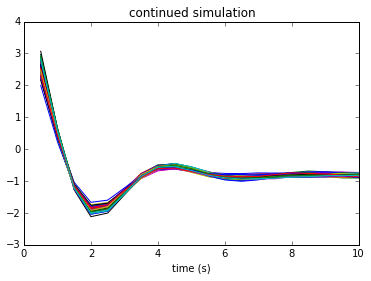

In [13]:
# then, plot to see if there is transient or not
figure(2)
plot(array(bold_time) / 1000.0, array(bold_data)[:, 0, :, 0])
title('continued simulation')
xlabel('time (s)')